# Salary Prediction Demo 03

In this demo, we go through the process of model training and evaluation

Bear in mind that this process is very iterative; and more than a few times insights from this stage require us to go back to earlier stages to modify the data cleaning, and feature engineering

## Imports

In [1]:
import os
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
import sklearn
scaler = StandardScaler()

In [2]:
def describe_feature(x): 
    v = df_meta[df_meta['Var'] == x]['Description'].values
    if len(v) == 0:
        return ''
    else:
        return v[0]

In [3]:
def _prepare_data(df, target  = 'REARNING', 
                  cols        = None, 
                  cat_cols    = None, 
                  encode_cats = True,
                  verbose     = True):
    
    if cols is None:
        cols = df.columns
    
    categorical_features = []
    if cat_cols is not None:
        categorical_features = cat_cols #[c for c in cats if c in cols]

    valid_cols = [c for c in cols if c in df.columns]
    df_X = df[valid_cols].copy()
    for c in df_X.columns:
        df_X[c] = df_X[c].astype(float, errors='ignore')
    assert target in df_X.columns

    feature_names = [x for x in list(df_X.columns) if x!=target]

    # ordinal encode the categorical features
    le_fitted ={}
    if encode_cats:
        for feature in categorical_features:
            le                 = preprocessing.LabelEncoder()
            le_fitted[feature] = le.fit(df_X[feature].values)
            df_X[feature]      = le_fitted[feature].transform(df_X[feature])
    
        if verbose and len(categorical_features)>0:
            print("Cardinalities")
            print("=============")
            for c in categorical_features:
                print(f"{c:<25} : {len(le_fitted[c].classes_)}")
            
    return df_X, le_fitted

def _split_data(df_X, target, scaler=None, shuffle=True):
    
    X = np.array(df_X.drop(target, axis=1), dtype=float)
    y = np.array(df_X[target], dtype=float)
    
    if shuffle:
            X, y = sklearn.utils.shuffle(X, y)

    n = X.shape[0]
    n_test = int(n*0.05)
    
    if scaler:
        scaler.fit(X)
        X = scaler.transform(X)

    X_train = X[n_test:,:]
    y_train = y[n_test:]

    X_test = X[:n_test,:]
    y_test = y[:n_test]
    
    return X_train, y_train, X_test, y_test

def _regression_metrics(model, X_test, y_test, verbose=True):
    results = {}
    # how did we do?
    results['score'] =model.score(X_test, y_test) 
    if verbose:
        print(f"Score                          : {results['score']:.2f}")

    # the mean error on prediction
    results['mean_abs_err'] = np.abs(model.predict(X_test) - y_test).mean()
    if verbose:
        print(f"Average Error                  : ${results['mean_abs_err']:.0f}")

    r = (model.predict(X_test) > 50000) == (y_test > 50000)
    results['class_err'] = 100 * sum(r) / len(r)
    if verbose:
        print(f"Classification (>$50,000) acc. : {results['class_err']:.2f}")
    
    return results

def combine_rare_classes(df, col, r=0.1, map_to='other'):
    
    gb = df[[col]].copy()
    gb['count'] = 1
    gb = gb[[col, 'count']].copy().groupby(col).sum().reset_index().sort_values(col, ascending=False)
    gb['count'] = 100*gb['count'] / sum(gb['count'])
    map_to_values = gb[gb['count'] < r][col].values
    
    print(fr"Removing {len(map_to_values)} classes out of {len(df[col].unique())}")
    
    mapper = {k:map_to for k in map_to_values}

    return mapper, gb

In [4]:
from helper import load_data

# identify numerical columns -> those which have a distance measure
num_cols = [
    'AGE',
    'YEARWRK',
    'FERTIL',
    'HOUR89',
    'HOURS',
    'RIDERS',
    'WEEK89', 
    'TRAVTIME',
    'YRSSERV',
    'REARNING',
    'INCOME1',
    'PWGT1',
    'DEPART',
    'RIDERS',
    'TRAVTIME'
]

# Stage 1 :  Data Preparation

## 1.1 Load Data

In [79]:
# metadata
df_meta, all_codes = load_data(r"/Users/tom.jubb/Documents/data/us_census/", verbose=False)

# cleaned dataset
df = pd.read_csv('us_census_data_cleaned_6.csv').drop('Unnamed: 0', axis=1)

In [80]:
# provide some sensible bounds
TARGET = 'REARNING'

# exclude irrelevant data
df = df[df['AGE']      > 18]
df = df[df['AGE']      < 90]

df = df[df['REARNING'] > 5000]
df = df[df['REARNING'] < 140000]

In [81]:
# drop RSPOUSE, since MARITAL provides duplicate information
# df = df.drop('RSPOUSE', axis=1)

In [82]:
# remove rare classes
mapper, gb = combine_rare_classes(df, 'RACE', 2.0, map_to = 'Other Race 700 799, 986 999')
df['RACE'] = df['RACE'].apply(lambda x: mapper.get(x, x))

Removing 59 classes out of 62


In [88]:
df['POB_CONTINENT'] = df['POB_CONTINENT'].apply(lambda x: 'NA' if x != x else x)

In [89]:
uninformative_columns = []
for c in df.columns:
    if len(df[c].unique()) == 1:
        print(c)
        uninformative_columns += [c]
df = df.drop(uninformative_columns, axis=1)

WORK89


In [90]:
df = df.drop(['OCCUP_JOB', 'INDUSTRY_CAT', 'PWGT1', 'MULTILINGUAL'], axis=1)

In [91]:
print(f"Rows: {df.shape[0]} Features: {df.shape[1]}")

Rows: 922769 Features: 56


## 1.2 Decide on Features

In [92]:
cats = [c for c in df.columns if c not in num_cols]

In [93]:
print("===== FEATURE LIST ======")
for x in list(df.columns):
    
    try:
        vartype = 'NUM' if x in num_cols else 'CAT'
        if vartype == 'CAT':
            card = len(df[x].unique())
            print(f"{x:<20} - {vartype} - {card:<4} - {describe_feature(x)}")
        else:
            print(f"{x:<20} - {vartype} -      - {describe_feature(x)}")
    except:
        print(x)

===== FEATURE LIST ======
AGE                  - NUM -      - Age
ANCSTRY1             - CAT - 255  - Ancestry First Entry See Appendix I Ance
ANCSTRY2             - CAT - 192  - Ancestry Second Entry See Appendix I Anc
CITIZEN              - CAT - 2    - Citizenship
CLASS                - CAT - 8    - Class of Worker
DEPART               - NUM -      - Time of Departure for Work Hour and Minu
DISABL1              - CAT - 2    - Work Limitation Stat.
ENGLISH              - CAT - 5    - Ability to Speak English
FEB55                - CAT - 2    - Served February 1955 July 1964
FERTIL               - NUM -      - No. of Chld. Ever Born
HISPANIC             - CAT - 56   - Detailed Hispanic Origin Code See Append
HOUR89               - NUM -      - Usual Hrs. Worked Per Week Last Yr. 1989
HOURS                - NUM -      - Hrs. Worked Last Week
IMMIGR               - CAT - 11   - Yr. of Entry
INDUSTRY             - CAT - 243  - Ind. See Appendix I Ind..lst
KOREAN               - CAT - 2  

In [94]:
df.head()

,AGE,ANCSTRY1,ANCSTRY2,CITIZEN,CLASS,DEPART,DISABL1,ENGLISH,FEB55,FERTIL,...,YEARSCH,YRSSERV,YEARSCH_CAT,OCCUP_SUM,OCCUP_MAJ,INDUSTRY_SUM,POB_USA,POB_CONTINENT,POB_COUNTRY,POB_STATE
0,43,50,999,True,Fed. Gov. Emp.,260,2,0,0,0,...,15,4,Masters Degree,MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS,"Executive, Administrative, and Managerial Occu...",PUBLIC ADMINISTRATION,True,NA,US,Alabama
3,27,148,999,True,Emp. of a Private for Profit Company or,540,2,0,0,0,...,14,0,Bachelors Degree,"TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,MANUFACTURING,True,NA,US,Alabama
5,31,999,999,True,Emp. of a Private for Profit Company or,435,2,0,0,0,...,11,0,"Some Coll., But No Degree","TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT O...",Sales Occupations,WHOLESALE TRADE,True,NA,US,Alabama
6,30,999,999,True,"Local Gov. Emp. City, County, Etc.",480,2,1,0,3,...,11,0,"Some Coll., But No Degree",SERVICE OCCUPATIONS,"Service Occupations, Except Protective and Hou...",PROFESSIONAL AND RELATED SERVICES,True,NA,US,Alabama
8,45,32,999,True,Emp. of a Private for Profit Company or,420,2,0,0,0,...,5,1,"5th, 6th, 7th, or 8th Grade","OPERATORS, FABRICATORS, AND LABORERS","Machine Operators, Assemblers, and Inspectors",MANUFACTURING,True,NA,US,Alabama


In [95]:
# keep_cols = [
#     'REARNING',
# #     'OCCUP',
# #     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
#     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',
# #     'multilingual'
    
#     'OCCUP_JOB',
#     'OCCUP_SUM',
#     'OCCUP_MAJ',
#     'INDUSTRY_CAT',
#     'INDUSTRY_SUM',
# ]

# Stage 2 : Model Exploration

Choose Metrics :

1. Score
2. Average Error in Prediction in $
3. Classification Error

np.sqrt(sum((df['REARNING'] - df['REARNING'].mean())**2) / df.shape[0])

- > $18,000 if we just use average wage



### 2.1 Advanced Feature Engineering : PCA

In [28]:
from sklearn.decomposition import PCA
pca = PCA(16)

In [29]:
# df_X, _ = _prepare_data(df, 
#                     target      = TARGET, 
#                     cols        = df.columns, 
#                     cat_cols    = [c for c in keep_cols if c not in num_cols], 
#                     encode_cats = True,
#                     verbose     = False)

In [30]:
df_X, _ = _prepare_data(df, 
                    target      = TARGET, 
                    cols        = keep_cols, 
                    cat_cols    = [c for c in keep_cols if c not in num_cols], 
                    encode_cats = True,
                    verbose     = True)

Cardinalities
RACE                      : 3
SEX                       : 2
MARITAL                   : 5
ENGLISH                   : 5
MEANS                     : 12
CITIZEN                   : 2
YEARSCH                   : 17
CLASS                     : 8
OCCUP_JOB                 : 504
OCCUP_SUM                 : 7
OCCUP_MAJ                 : 14
INDUSTRY_CAT              : 238
INDUSTRY_SUM              : 14


In [31]:
# split data into inputs and outputs (truth)
# df_X = df_encoded.copy()
X_pca = np.array(df_X.drop(TARGET, axis=1), dtype=float)

# note PCA is sensitive to magnitude, so standard scaler must be applied
scaler.fit(X_pca)
X_pca = scaler.transform(X_pca)

feature_names = [x for x in list(df_X.columns) if x!=TARGET]

X_pca = pca.fit_transform(X_pca)

c=0.0
for a,b in zip(pca.get_feature_names_out(), pca.explained_variance_ratio_):
    c += b
    print(f"{a:<12} - {100*b:<6.3f} - {100*c:.3f}")

pca0         - 10.627 - 10.627
pca1         - 9.142  - 19.769
pca2         - 7.540  - 27.308
pca3         - 6.949  - 34.257
pca4         - 6.302  - 40.559
pca5         - 6.049  - 46.608
pca6         - 5.638  - 52.247
pca7         - 5.258  - 57.504
pca8         - 4.930  - 62.435
pca9         - 4.496  - 66.931
pca10        - 4.368  - 71.299
pca11        - 4.261  - 75.560
pca12        - 4.065  - 79.625
pca13        - 3.872  - 83.497
pca14        - 3.701  - 87.199
pca15        - 3.578  - 90.777


In [32]:
for p, k in zip(pca.components_[0], [c for c in keep_cols if c != TARGET]):
    print(f"{p:<7.2f}, {k}")

0.10   , RACE
0.59   , SEX
0.30   , HOURS
-0.04  , AGE
-0.58  , FERTIL
0.09   , WEEK89
-0.00  , MARITAL
-0.05  , ENGLISH
0.28   , YRSSERV
0.05   , MEANS
0.04   , CITIZEN
0.10   , YEARSCH
0.09   , CLASS
-0.12  , DEPART
-0.01  , PWGT1
-0.08  , OCCUP_JOB
-0.14  , OCCUP_SUM
0.10   , OCCUP_MAJ
-0.06  , INDUSTRY_CAT
-0.20  , INDUSTRY_SUM


## 2.1 First Attempt : Linear Model, All Data

- Linear regression is a very simple and explaianable model
- Let's use all the data

- Scaling
- Shuffling

**Best Results** : $$ \$9,200 $$

### 2.1.1 First Try

Let's just fit a simple Linear Regression model to **all** the data

**Results** : $$ \$9,700 $$

In [96]:
cols = [d for d in df.columns if d not in ['MIGSTATE', 'POWSTATE']]

df_X, lecs = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = cols, 
                        cat_cols    = [c for c in cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows: {df_X.shape[0]} Features: {df_X.shape[1]}")

Rows: 922769 Features: 54


In [97]:
# scale features so we can compare the size of the coefficients
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

Training data : 876631 
Test data     : 46138


In [98]:
model = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.36
Average Error                  : $9768
Classification (>$50,000) acc. : 92.81


### 2.1.2 Sample multiple test sets to find model error

Model training is subject to randomness and results vary; we need to know the error on the metrics to be confident in performance and to be able to determine if new experiments are better than the current best model.

**Results :** $$ \$9,700 +/- 35 $$

In [19]:
results = []
coefs   = []
for i in range(10):
    print(fr"{i+1}/{10}", end ='\r')
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target=TARGET, 
                                                   scaler=scaler, 
                                                   shuffle=True)
    reg = LinearRegression().fit(X_train, y_train)
    coefs   += [reg.coef_]
    results += [_regression_metrics(reg, X_test, y_test, verbose=False)]
    
err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Error : $9721.70 +/- 56.59


### 2.1.3 How do we visualize the model parameters?

Visualizing model parameters can offer insights into issues with the model (or explain some of its behaviour). Although not always possible, it is certainly possible for linear regression models

In [20]:
xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_, yvals_err_ = np.array(coefs).mean(axis=0), np.array(coefs).std(axis=0)

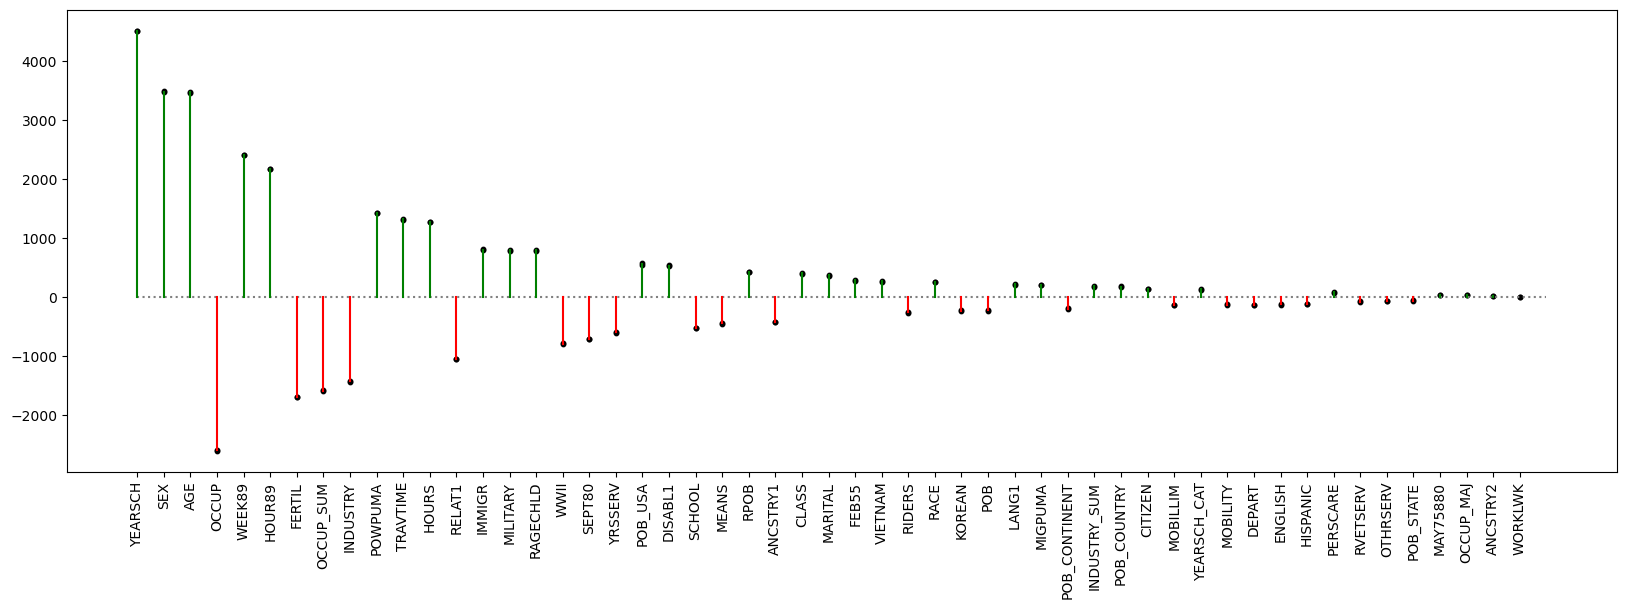



MOST IMPORTANT FEATURES

AGE        3483.04    Age
HOUR89     2172.04    Usual Hrs. Worked Per Week Last Yr. 1989
OCCUP      -2590.91   Occupation See Appendix I Occup.lst
SEX        3493.44    Sex
WEEK89     2417.55    Wks. Worked Last Yr. 1989
YEARSCH    4519.52    Ed. Attainment


LEAST IMPORTANT FEATURES

ANCSTRY2   17.85      Ancestry Second Entry See Appendix I Anc
MAY75880   38.86      Served May 1975 to August 1980
WORKLWK    -3.85      Worked Last Week
OCCUP_MAJ  39.48      


In [21]:
fig, ax = plt.subplots(1,1,figsize=(20,6))

idx = np.argsort(np.abs(yvals_))[::-1]
xvals     = np.array([xvals_[i] for i in idx])
yvals     = np.array([yvals_[i] for i in idx])
yvals_err = np.array([yvals_err_[i] for i in idx])

plt.scatter(xvals, yvals - yvals_err, color="black", s=10)
plt.scatter(xvals, yvals + yvals_err, color="black", s=10)

plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
    
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((reg.coef_ > 2000) | (reg.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(reg.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

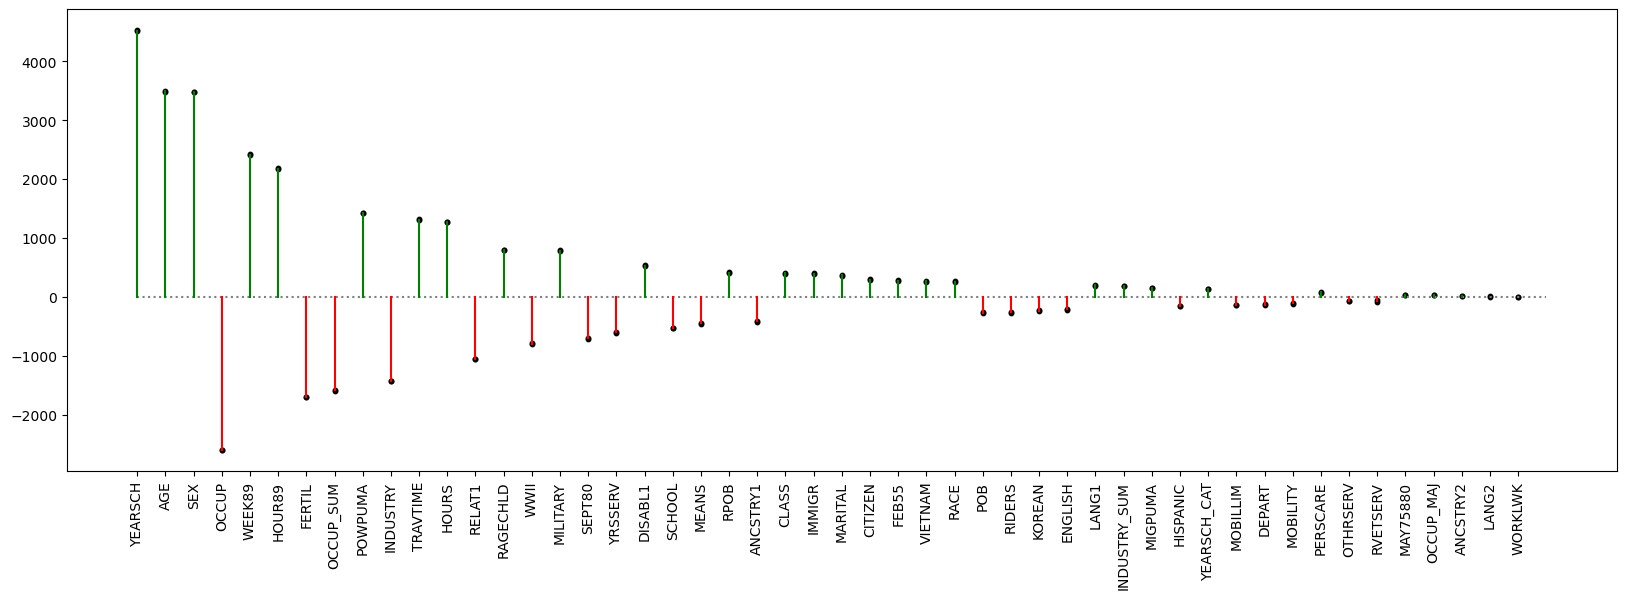



MOST IMPORTANT FEATURES

AGE        3495.83    Age
HOUR89     2169.39    Usual Hrs. Worked Per Week Last Yr. 1989
OCCUP      -2594.45   Occupation See Appendix I Occup.lst
SEX        3483.44    Sex
WEEK89     2417.90    Wks. Worked Last Yr. 1989
YEARSCH    4519.83    Ed. Attainment


LEAST IMPORTANT FEATURES

ANCSTRY2   16.00      Ancestry Second Entry See Appendix I Anc
LANG2      11.51      Language Spoken At Home See Appendix I L
MAY75880   36.41      Served May 1975 to August 1980
RVETSERV   -43.48     Veteran Per. of Srvc.
WORKLWK    6.27       Worked Last Week
OCCUP_MAJ  39.38      


### 2.1.4 More selective over columns

We can drop some of the less useful parameters to create a simpler model without losing too much accuracy

**Result** $$ \$9,700 $$

In [22]:
idx = np.argsort(np.abs(reg.coef_))[:25]

cols = [c for c in df_X.columns if c !=TARGET]
cols = [cols[i] for i in idx]

keep_cols = [c for c in df_X.columns if c not in cols ]
keep_cols

['AGE',
 'ANCSTRY1',
 'CLASS',
 'DISABL1',
 'FEB55',
 'FERTIL',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'REARNING',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'WEEK89',
 'WWII',
 'YEARSCH',
 'YRSSERV',
 'OCCUP_SUM',
 'POB_USA']

In [45]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]


In [23]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

print(f"Rows          : {df_X.shape[0]} Features: {df_X.shape[1]}")

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

print("======= RESULTS =========")
reg = LinearRegression().fit(X_train, y_train)
_ = _regression_metrics(reg, X_test, y_test)

Rows          : 922769 Features: 29
Training data : 876631 
Test data     : 46138
======= RESULTS =========
Score                          : 0.37
Average Error                  : $9768
Classification (>$50,000) acc. : 92.80


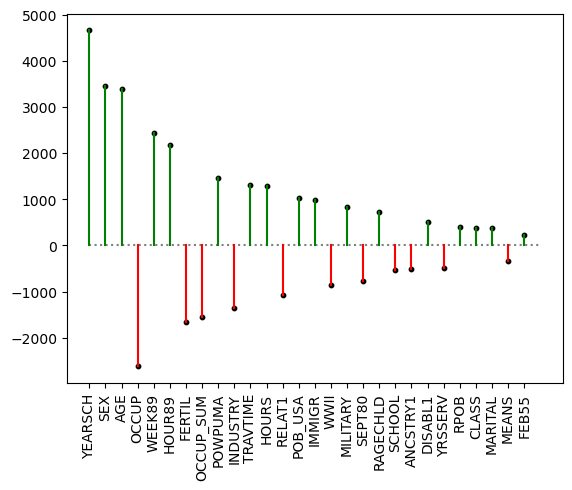



MOST IMPORTANT FEATURES

YEARSCH    4659.50    Ed. Attainment
SEX        3448.14    Sex
AGE        3386.98    Age
OCCUP      -2618.88   Occupation See Appendix I Occup.lst
WEEK89     2432.23    Wks. Worked Last Yr. 1989


LEAST IMPORTANT FEATURES

RPOB       398.52     Place of Birth Recode
CLASS      387.53     Class of Worker
MARITAL    371.10     Marital Stat.
MEANS      -336.01    Means of Transportation to Work
FEB55      221.05     Served February 1955 July 1964


In [24]:

xvals_ = [c for c in df_X.columns if c !=TARGET]
yvals_ = reg.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx]
yvals = [yvals_[i] for i in idx]
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_X.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[-5:][::-1]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[::-1][-5:]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

### 2.5 Technique : Use dummy variables for cats

In linear regression we encode categorical features and fit a line to them; this does not really make sense

TODO : remove rare categories from high cardinality vars

**Result** : $$ \$9,200 $$

In [25]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART'
# ]
keep_cols

['AGE',
 'ANCSTRY1',
 'CLASS',
 'DISABL1',
 'FEB55',
 'FERTIL',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'REARNING',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'WEEK89',
 'WWII',
 'YEARSCH',
 'YRSSERV',
 'OCCUP_SUM',
 'POB_USA']

Cardinalities (will be mapped to binary features):
CLASS     , 8
DISABL1   , 2
FEB55     , 2
IMMIGR    , 11
INDUSTRY  , 243
MARITAL   , 5
MEANS     , 12
MILITARY  , 2
RELAT1    , 13
SCHOOL    , 3
SEPT80    , 2
SEX       , 2
WWII      , 2
YEARSCH   , 17
OCCUP_SUM , 7
POB_USA   , 2
======= Fitting ========
======= Results ========
Score                          : 0.42
Average Error                  : $9197
Classification (>$50,000) acc. : 92.94


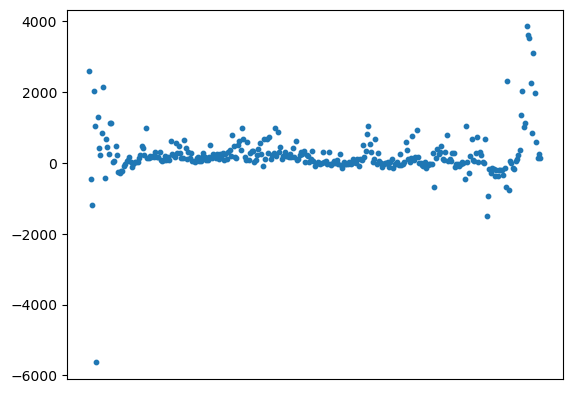

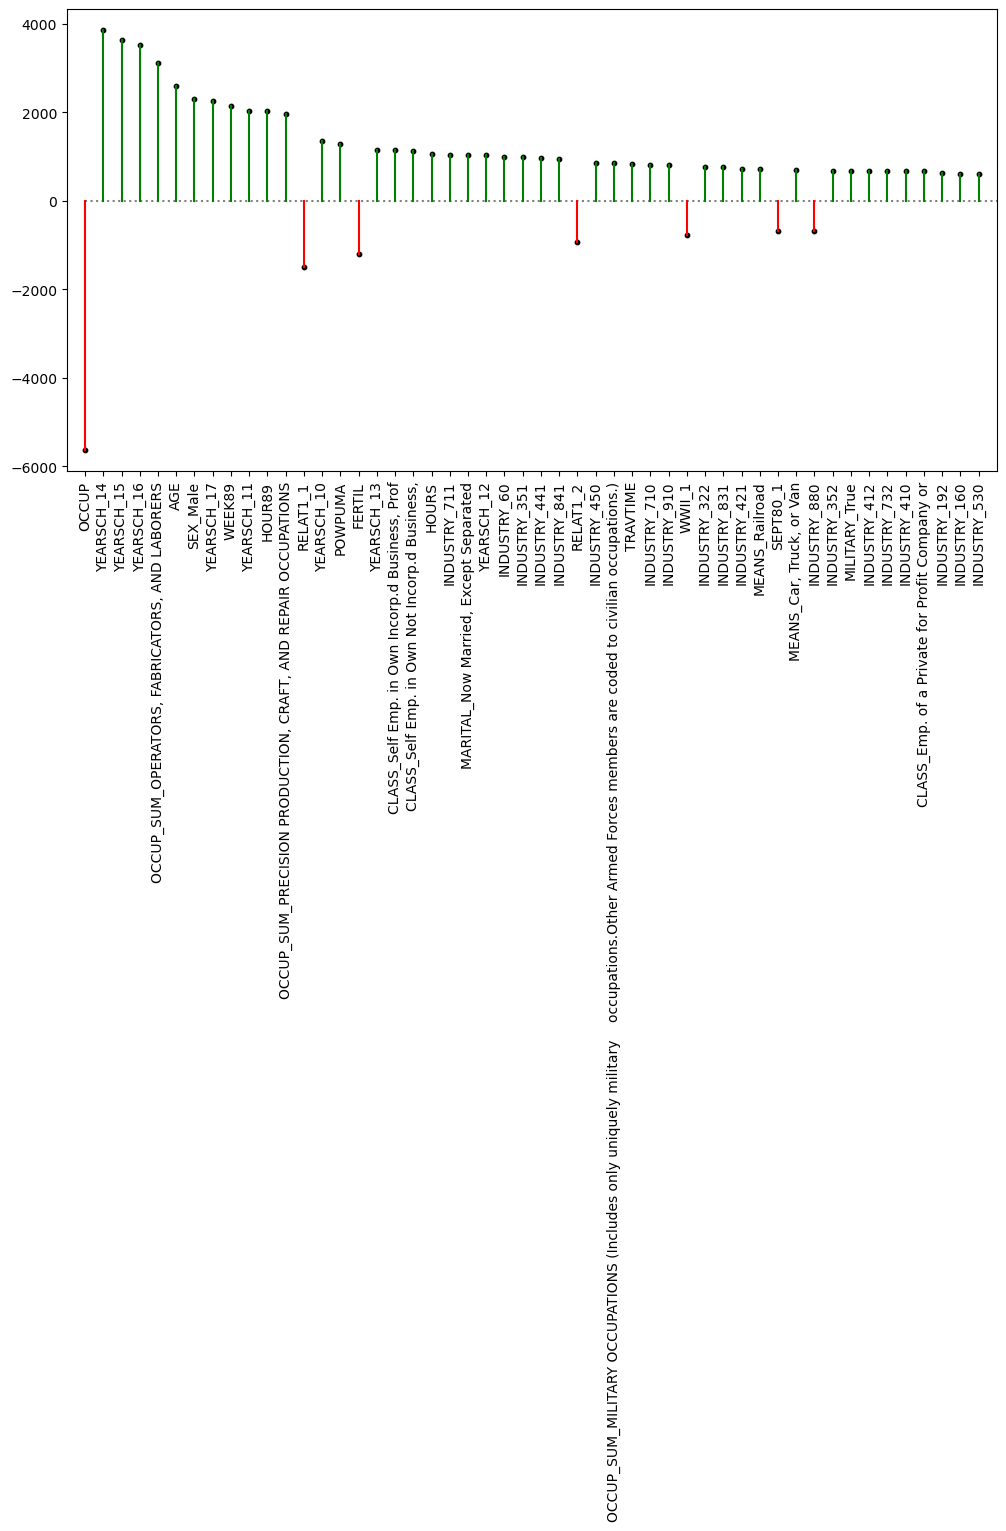



MOST IMPORTANT FEATURES

IMMIGR_4   4659.50    
FEB55_1    3448.14    
AGE        3386.98    Age
CLASS_Fed. Gov. Emp. -2618.88   
IMMIGR_2   2432.23    
POWPUMA    2173.93    Place of Work Puma State Dependent
OCCUP      -1661.84   Occupation See Appendix I Occup.lst
IMMIGR_6   -1541.55   
CLASS_Local Gov. Emp. City, County, Etc. 1454.27    
TRAVTIME   -1361.56   Travel Time to Work


LEAST IMPORTANT FEATURES

CLASS_Self Emp. in Own Incorp.d Business, Prof 730.00     
CLASS_Working Without Pay in Fam. Bus. or Farm -532.32    
ANCSTRY1   -512.90    Ancestry First Entry See Appendix I Ance
HOUR89     505.44     Usual Hrs. Worked Per Week Last Yr. 1989
IMMIGR_5   -485.56    
CLASS_State Gov. Emp. 398.52     
FERTIL     387.53     No. of Chld. Ever Born
WEEK89     371.10     Wks. Worked Last Yr. 1989
YRSSERV    -336.01    Yrs. of Active Duty Military Srvc.
HOURS      221.05     Hrs. Worked Last Week


In [26]:
# manually exclude some cats which would pollute the input space
dummy_cols = [k for k in keep_cols if k not in num_cols + ['OCCUP', 'ANCSTRY1', 'POWPUMA', 'RPOB','RAGECHLD']]
print("Cardinalities (will be mapped to binary features):")
for k in dummy_cols:
    print(fr"{k:<10}, {len(df[k].unique())}")

df_dummy = pd.get_dummies(df[keep_cols].iloc[:,:],
                          columns=dummy_cols, 
                          drop_first=True)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if (c not in num_cols) and (c not in dummy_cols)], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

print("======= Fitting ========")
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(xvals, yvals, color="black", s=10)
ax.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")

for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[-10:][::-1]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.abs(reg.coef_).argsort()[::-1][-10:]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {reg.coef_[i]:<10.2f} {description}")

(100000, 146)
======= Results ========
Score                          : -0.23
Average Error                  : $10674
Classification (>$50,000) acc. : 90.74


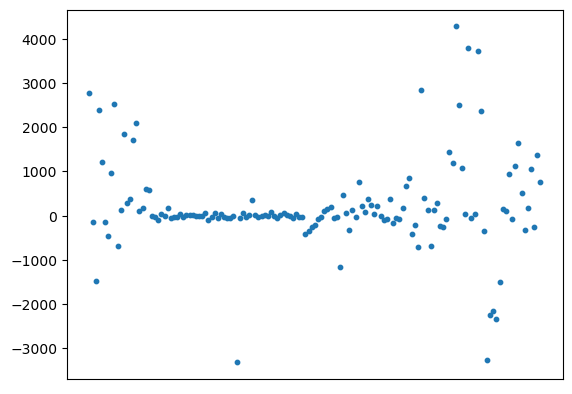

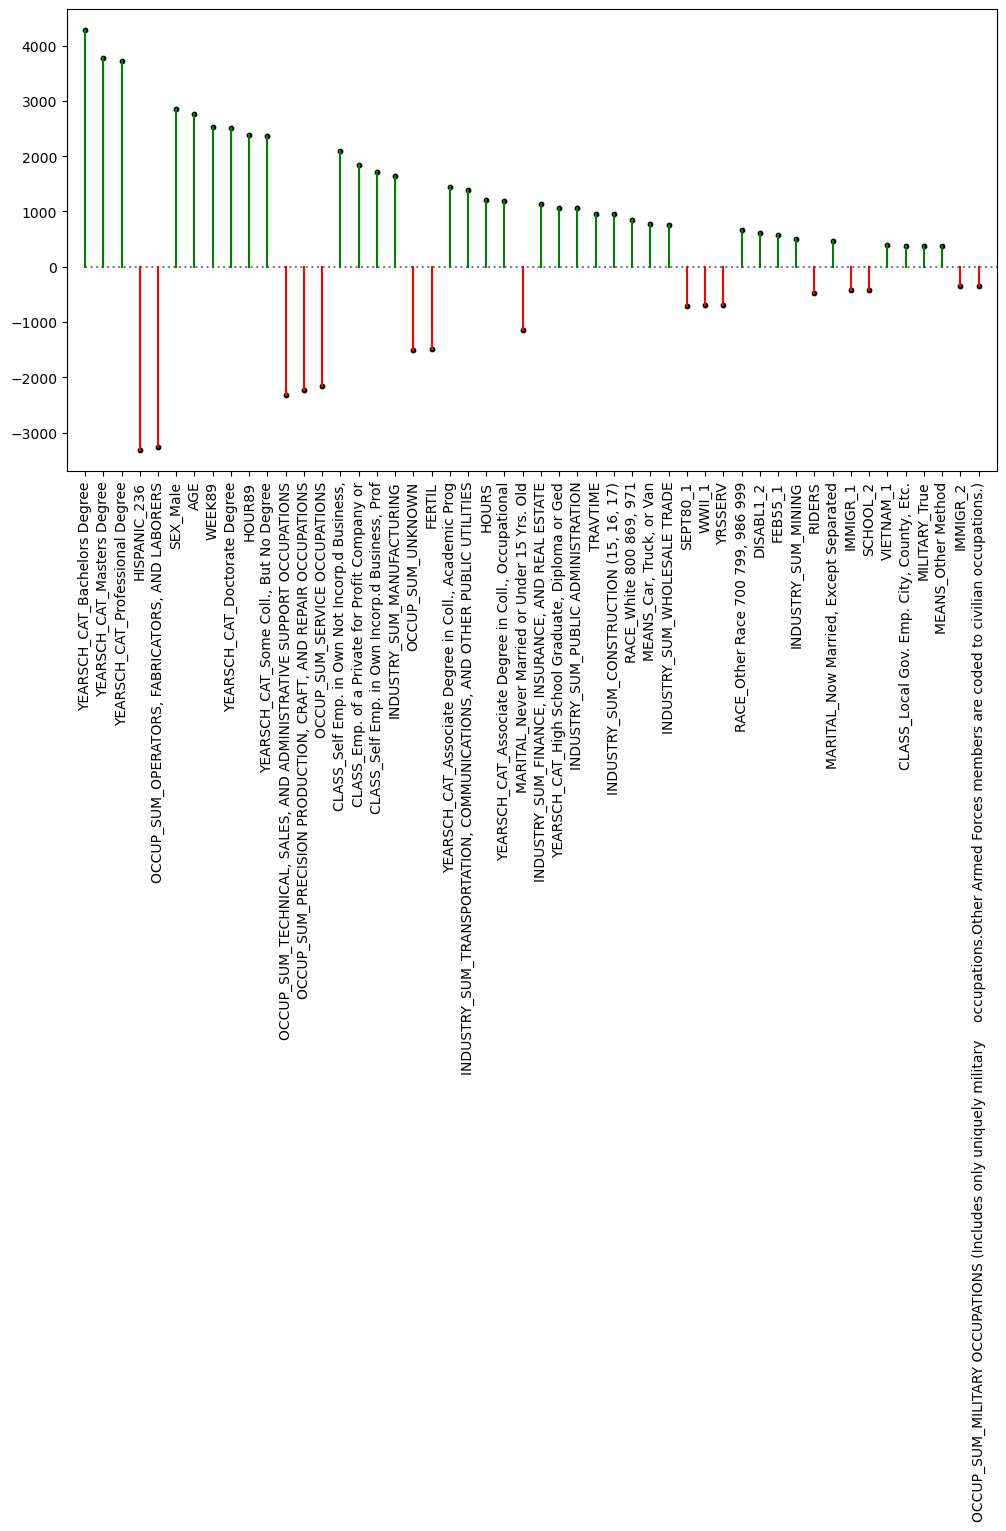



MOST IMPORTANT FEATURES

AGE        2766.45    Age
HOUR89     2389.25    Usual Hrs. Worked Per Week Last Yr. 1989
WEEK89     2526.65    Wks. Worked Last Yr. 1989
CLASS_Self Emp. in Own Not Incorp.d Business, 2101.85    
HISPANIC_236 -3317.66   
SEX_Male   2844.45    
YEARSCH_CAT_Bachelors Degree 4279.64    
YEARSCH_CAT_Doctorate Degree 2506.40    
YEARSCH_CAT_Masters Degree 3783.76    
YEARSCH_CAT_Professional Degree 3722.91    
YEARSCH_CAT_Some Coll., But No Degree 2356.48    
OCCUP_SUM_OPERATORS, FABRICATORS, AND LABORERS -3265.21   
OCCUP_SUM_PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS -2237.17   
OCCUP_SUM_SERVICE OCCUPATIONS -2152.99   
OCCUP_SUM_TECHNICAL, SALES, AND ADMINISTRATIVE SUPPORT OCCUPATIONS -2328.43   


LEAST IMPORTANT FEATURES

HISPANIC_1 -18.38     
HISPANIC_2 -21.10     
HISPANIC_4 32.90      
HISPANIC_199 -15.95     
HISPANIC_204 -39.55     
HISPANIC_209 -25.20     
HISPANIC_210 45.08      
HISPANIC_211 -33.44     
HISPANIC_212 20.76      
HISPANIC_213 1

In [32]:
drop_cols = [
     'OCCUP', 
     'INDUSTRY',
     'OCCUP_JOB',
     'OCCUP_MAJ',
     'INDUSTRY_CAT',
     'ANCSTRY1',
     'ANCSTRY2',
     'RELAT1',
     'RELAT2',
     'ASERVPER',
     'AVETS1',
    
     'POB',
     'RPOB',
     'MIGPUMA',
     'POWPUMA',
     'MIGSTATE',
     'POWSTATE',
     'RAGECHLD',
    
     'LANG1',
     'LANG2',
     'ENGLISH',
    
     'RELAT2',
     'SUBFAM1',
     'SUBFAM2',
     
     'RSPOUSE',  
     'RVETSERV', # duplicate the other military categories
     'YEARSCH',  # duplicate
]

keep_cols = [d for d in df.columns if d not in drop_cols]

df_dummy = pd.get_dummies(df[keep_cols].iloc[:100000,:],
                          columns=[c for c in keep_cols if c not in num_cols], 
                          drop_first=True)
print(df_dummy.shape)

df_X, _ = _prepare_data(df_dummy, 
                        target      = TARGET, 
                        cols        = df_dummy.columns, 
                        cat_cols    = [c for c in df_dummy.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = False)

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=scaler, shuffle=True)

model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_regression_metrics(model, X_test, y_test)



plt.scatter([c for c in df_dummy.columns if c !=TARGET], model.coef_, s=10)
plt.xticks([])
plt.show()

limit=50
xvals_ = [c for c in df_dummy.columns if c !=TARGET]
yvals_ = model.coef_
idx = np.argsort(np.abs(yvals_))[::-1]
xvals = [xvals_[i] for i in idx][:limit]
yvals = [yvals_[i] for i in idx][:limit]

fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.scatter(xvals, yvals, color="black", s=10)
plt.plot([0,df_dummy.shape[1]-1],[0,0], color="gray", ls=":")
for c, coef in zip(xvals, yvals):
    color = 'g' if coef>0 else 'r'
    plt.plot([c,c],[0,coef], color=color)
plt.xticks(rotation=90)
plt.xlim([-1, len(xvals)])
plt.show()

print('\n')
print("MOST IMPORTANT FEATURES\n")
for i in np.where((model.coef_ > 2000) | (model.coef_ < -2000))[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")
    

print('\n')
print("LEAST IMPORTANT FEATURES\n")
for i in np.where(abs(model.coef_) < 50 )[0]:
    col_name = df_X.drop(TARGET, axis=1).columns[i]
    description = describe_feature(col_name)
    print(f"{col_name:<10} {model.coef_[i]:<10.2f} {description}")

## 2.2 Second Attempt : Different Model Choices

- All data, different models
- Benchmark Linear Regression

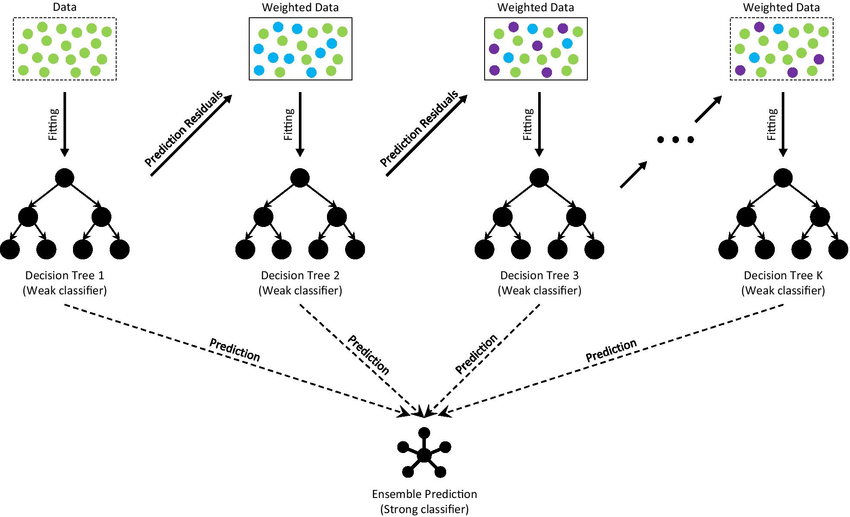

**Result** GBR : $$ \$8,700 $$

In [132]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = None, 
                        cat_cols    = [c for c in df.columns if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
ANCSTRY1                  : 255
ANCSTRY2                  : 192
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
ENGLISH                   : 5
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
INDUSTRY                  : 243
KOREAN                    : 2
LANG1                     : 2
LANG2                     : 213
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MIGPUMA                   : 109
MIGSTATE                  : 52
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OCCUP                     : 504
OTHRSERV                  : 2
PERSCARE                  : 2
POB                       : 267
POWPUMA                   : 108
POWSTATE                  : 52
RACE                      : 3
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
RVETSERV                  : 12
SC

In [34]:
# benchmark
model = LinearRegression().fit(X_train, y_train)
print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.37
Average Error                  : $9696
Classification (>$50,000) acc. : 92.89


In [133]:
# Try and gradient boosted tree algorithm...
model = GradientBoostingRegressor(n_estimators  =100, 
                                  learning_rate =0.1,
#                                 max_depth     =5, 
                                  random_state  = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)


KeyboardInterrupt



======= Results ========
Score                          : 0.46
Average Error                  : $8700
Classification (>$50,000) acc. : 93.39


Gradient boosted decision trees

In [39]:
print("======= Feature Importance ========")

importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

======= Feature Importance ========
YEARSCH    - 0.207 - 0.21 - Ed. Attainment
OCCUP      - 0.182 - 0.39 - Occupation See Appendix I Occup.lst
AGE        - 0.121 - 0.51 - Age
HOUR89     - 0.088 - 0.60 - Usual Hrs. Worked Per Week Last Yr. 1989
RELAT1     - 0.073 - 0.67 - Rel. or Not Related or Grp. Qtrs.
SEX        - 0.057 - 0.73 - Sex
WEEK89     - 0.054 - 0.78 - Wks. Worked Last Yr. 1989
RAGECHLD   - 0.051 - 0.83 - Presence and Age of Own Chld.
FERTIL     - 0.037 - 0.87 - No. of Chld. Ever Born
INDUSTRY   - 0.027 - 0.90 - Ind. See Appendix I Ind..lst
HOURS      - 0.019 - 0.92 - Hrs. Worked Last Week
POWPUMA    - 0.016 - 0.93 - Place of Work Puma State Dependent
TRAVTIME   - 0.011 - 0.94 - Travel Time to Work
CLASS      - 0.009 - 0.95 - Class of Worker
ANCSTRY1   - 0.007 - 0.96 - Ancestry First Entry See Appendix I Ance
MIGSTATE   - 0.007 - 0.97 - Migration State or Foreign Country Code
MARITAL    - 0.006 - 0.97 - Marital Stat.
INDUSTRY_SUM - 0.005 - 0.98 - 
OCCUP_MAJ  - 0.004 - 0.98 -

Let's try a few more models

In [40]:
models = []
models.append(('LR',   LinearRegression()))
models.append(('GBR',  GradientBoostingRegressor()))
models.append(('DTR',  DecisionTreeRegressor()))
models.append(('RFR',  RandomForestRegressor()))


for name, model in models:
    model.fit(X_train[:100000,:], y_train[:100000])
    print("======= Results ========")
    _ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.37
Average Error                  : $9681
Classification (>$50,000) acc. : 92.88
======= Results ========
Score                          : 0.46
Average Error                  : $8709
Classification (>$50,000) acc. : 93.33
======= Results ========
Score                          : -0.14
Average Error                  : $12364
Classification (>$50,000) acc. : 89.63
======= Results ========
Score                          : 0.46
Average Error                  : $8714
Classification (>$50,000) acc. : 93.03


In [45]:
# keep_cols = [
#     'REARNING',
#     'OCCUP',
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',
    
# #     'WORKLWK',
# #     'MILITARY',  
# #     'SEPT80',
# #     'WWII',
# #     'SCHOOL',
# #     'POWSTATE',
# #     'PWGT1',
# #     'RIDERS',
# #     'VIETNAM',
# #     'KOREAN',

# #     'OCCUP_JOB',
# #     'OCCUP_SUM',
# #     'OCCUP_MAJ',
# #     'INDUSTRY_CAT',
# #     'INDUSTRY_SUM',
# ]

keep_cols

['AGE',
 'CITIZEN',
 'CLASS',
 'DEPART',
 'DISABL1',
 'FEB55',
 'FERTIL',
 'HISPANIC',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'KOREAN',
 'MARITAL',
 'MAY75880',
 'MEANS',
 'MILITARY',
 'MOBILITY',
 'MOBILLIM',
 'OTHRSERV',
 'PERSCARE',
 'PWGT1',
 'RACE',
 'REARNING',
 'RIDERS',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'VIETNAM',
 'WEEK89',
 'WORKLWK',
 'WWII',
 'YRSSERV',
 'YEARSCH_CAT',
 'OCCUP_SUM',
 'INDUSTRY_SUM']

In [41]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols, 
                        cat_cols    = [c for c in keep_cols if c not in num_cols], 
                        encode_cats = True,
                        verbose     = True)
print('\n')
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

Cardinalities
CITIZEN                   : 2
CLASS                     : 8
DISABL1                   : 2
FEB55                     : 2
HISPANIC                  : 56
IMMIGR                    : 11
KOREAN                    : 2
MARITAL                   : 5
MAY75880                  : 2
MEANS                     : 12
MILITARY                  : 2
MOBILITY                  : 2
MOBILLIM                  : 2
OTHRSERV                  : 2
PERSCARE                  : 2
RACE                      : 3
SCHOOL                    : 3
SEPT80                    : 2
SEX                       : 2
VIETNAM                   : 2
WORKLWK                   : 2
WWII                      : 2
YEARSCH_CAT               : 17
OCCUP_SUM                 : 7
INDUSTRY_SUM              : 14




In [42]:
model = LinearRegression().fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.28
Average Error                  : $10492
Classification (>$50,000) acc. : 92.38


In [43]:
model = GradientBoostingRegressor(n_estimators    =100, 
                                  learning_rate   =1.0,
                                  random_state    = 0).fit(X_train, y_train)

print("======= Results ========")
_ = _regression_metrics(model, X_test, y_test)

======= Results ========
Score                          : 0.46
Average Error                  : $8862
Classification (>$50,000) acc. : 93.14


In [44]:
importance = {}
for a,b in zip(df_X.drop(TARGET, axis=1).columns, model.feature_importances_):
    importance[a] = b

run_total=0.0
for a,b in dict(sorted(importance.items(), key=lambda item: item[1])[::-1]).items():
    desc = describe_feature(a)
    run_total += b
    print(f"{a:<10} - {b:<5.3f} - {run_total:<3.2f} - {desc}")

OCCUP_SUM  - 0.232 - 0.23 - 
AGE        - 0.155 - 0.39 - Age
FERTIL     - 0.130 - 0.52 - No. of Chld. Ever Born
SEX        - 0.121 - 0.64 - Sex
YEARSCH_CAT - 0.103 - 0.74 - 
HOUR89     - 0.088 - 0.83 - Usual Hrs. Worked Per Week Last Yr. 1989
WEEK89     - 0.049 - 0.88 - Wks. Worked Last Yr. 1989
INDUSTRY_SUM - 0.034 - 0.91 - 
PWGT1      - 0.020 - 0.93 - Pers. Wgt
TRAVTIME   - 0.017 - 0.95 - Travel Time to Work
CLASS      - 0.016 - 0.96 - Class of Worker
HOURS      - 0.008 - 0.97 - Hrs. Worked Last Week
MEANS      - 0.005 - 0.98 - Means of Transportation to Work
MARITAL    - 0.004 - 0.98 - Marital Stat.
RACE       - 0.003 - 0.98 - Recoded Detailed Race Code Appendix C Ra
DEPART     - 0.003 - 0.99 - Time of Departure for Work Hour and Minu
DISABL1    - 0.002 - 0.99 - Work Limitation Stat.
RIDERS     - 0.002 - 0.99 - Vehicle Occupancy
YRSSERV    - 0.002 - 0.99 - Yrs. of Active Duty Military Srvc.
CITIZEN    - 0.002 - 1.00 - Citizenship
IMMIGR     - 0.001 - 1.00 - Yr. of Entry
HISPANIC   -

## 2.3 Third Attempt

So far, linear regression has given a good benchmark; and is quick to train; but other types of models perform significantly better.

- We use a selected group of features
- We use boosted decision trees; as these are superior to linear regression

**Best Result** : $$ \$8,500 $$


### 2.3.1 Automated Feature Selection

A very simple method : we can sequentially add features and accept/reject based on improvment to the model

In [56]:
keep_cols_0 = [
    'REARNING',
    'OCCUP']

# test_cols=[
#     'INDUSTRY',
#     'RACE',
#     'SEX',
#     'HOURS',
#     'AGE',
#     'FERTIL',
#     'WEEK89',
#     'MARITAL',
#     'ENGLISH',
#     'YRSSERV',
#     'MEANS',
#     'CITIZEN',
#     'YEARSCH',
#     'CLASS',
#     'DEPART',    
#     'WORKLWK',
#     'MILITARY',  
#     'SEPT80',
#     'WWII',
#     'SCHOOL',
#     'POWSTATE',
#     'PWGT1',
#     'RIDERS',
#     'VIETNAM',
#     'KOREAN',
#     'multilingual'
# ]

test_cols = [d for d in df.columns if d not in keep_cols_0]

keep_cols_1 = keep_cols_0

df_2 = reduce_cardinality(df, 'OCCUP', 700)

baseline = 0.0
for t in test_cols:
    print("="*80)
    print("Testing addition of ", t)
    
    keep_cols_1 += [t]
    print("Features :", keep_cols_1)
    
    tmp = [c for c in keep_cols_1 if c != TARGET]
    tmp = [True if c not in num_cols else False for c in tmp]
    
#     tmp = [c for c in keep_cols_1 if c != TARGET]
#     tmp = [True if c not in num_cols else False for c in tmp]
    
#     gb = df.groupby('OCCUP').count().sort_values('AGE')['AGE']
#     low_occup_codes = set(list(gb[gb < 100].index))
#     repl = min(low_occup_codes)

#     df_2 = df.copy()
#     # df_2 = df_2[df['OCCUP'].apply(lambda x: x not in low_occup_codes)]
#     df_2['OCCUP'] = df['OCCUP'].apply(lambda x: repl if x in low_occup_codes else x)
    
    df_X, _ = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols_1, 
                            cat_cols    = [c for c in keep_cols_1 if c not in num_cols], 
                            encode_cats = True,
                            verbose     = False)

    X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET)

    model = HistGradientBoostingRegressor( 
                                 learning_rate=0.1,
#                                  max_depth=6, 
                                 max_bins=255,
                                 max_iter=140,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)

    _regression_metrics(model, X_test, y_test)
    
    score = model.score(X_test, y_test)
    if (score - baseline) > 0.001:
        # keep
        print("Keep!")
        baseline = score
    else:
        # reject
        print("Reject!")
        keep_cols_1 = keep_cols_1[:-1]

Old cardinality 504
New cardinality 222
Testing addition of  AGE
Features : ['REARNING', 'OCCUP', 'AGE']
======= Results ========
Score                          : 0.31
Average Error                  : $10150
Classification (>$50,000) acc. : 92.72
Keep!
Testing addition of  ANCSTRY1
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1']
======= Results ========
Score                          : 0.33
Average Error                  : $10023
Classification (>$50,000) acc. : 92.74
Keep!
Testing addition of  ANCSTRY2
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'ANCSTRY2']
======= Results ========
Score                          : 0.32
Average Error                  : $10022
Classification (>$50,000) acc. : 92.87
Reject!
Testing addition of  CITIZEN
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN']
======= Results ========
Score                          : 0.33
Average Error                  : $10084
Classification (>$50,000) acc. : 92.64
Keep!
Testing addition of  CLASS
Featur

======= Results ========
Score                          : 0.46
Average Error                  : $8668
Classification (>$50,000) acc. : 93.16
Reject!
Testing addition of  MIGSTATE
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', 'FEB55', 'FERTIL', 'HOUR89', 'HOURS', 'INDUSTRY', 'LANG1', 'MIGSTATE']
======= Results ========
Score                          : 0.48
Average Error                  : $8470
Classification (>$50,000) acc. : 93.10
Keep!
Testing addition of  MILITARY
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', 'FEB55', 'FERTIL', 'HOUR89', 'HOURS', 'INDUSTRY', 'LANG1', 'MIGSTATE', 'MILITARY']
======= Results ========
Score                          : 0.48
Average Error                  : $8423
Classification (>$50,000) acc. : 93.30
Keep!
Testing addition of  MOBILITY
Features : ['REARNING', 'OCCUP', 'AGE', 'ANCSTRY1', 'CITIZEN', 'CLASS', 'DEPART', 'DISABL1', 'ENGLISH', '

ValueError: Categorical feature at index 18 is expected to have a cardinality <= 255

In [531]:
keep_cols_1

['REARNING',
 'OCCUP',
 'INDUSTRY',
 'RACE',
 'SEX',
 'HOURS',
 'AGE',
 'WEEK89',
 'MARITAL',
 'ENGLISH',
 'YRSSERV',
 'YEARSCH',
 'CLASS',
 'SEPT80',
 'RIDERS',
 'VIETNAM',
 'KOREAN',
 'multilingual']

### 2.3.1 Gradient Boosted Trees with Categorical Variables

We have introduced the same problem with cat variables to GBDTs; even though these models are naturally less sensitive.

We can use **histogram** based trees to improve on this.

Due to complexity, the maximum cardinality for histogram based trees is 255, which is less than some of our features. We thus need to reduce the cardinality. We can do this by gathering all uncommon classes into a single "other" category.

**Result** : $$ \$8,100 $$

In [27]:
def reduce_cardinality(df, feature='OCCUP', group_below=700, new_value='other'):
    
    gb = df.groupby(feature).count().sort_values('AGE')['AGE']
    
    print(f"Old cardinality {gb.shape[0]}")

    low_occup_codes = set(list(gb[gb < group_below].index))
    repl = new_value # min(low_occup_codes)

    df_2 = df.copy()
    df_2[feature] = df[feature].apply(lambda x: repl if x in low_occup_codes else x)
    
    percentage_removed = 100 * sum(df_2[feature] == new_value)/df_2.shape[0]
    
    print(f"New cardinality {len(df_2[feature].unique())}")
    print(fr"{len(low_occup_codes)}/{len(df[feature].unique())} classes ({percentage_removed:.2f}% data) reduced to class {new_value}")
    
    return df_2

In [28]:
# df_2 = reduce_cardinality(df, 'OCCUP', 700 )

df_2 = reduce_cardinality(df,   'OCCUP', 700, 999)
df_2 = reduce_cardinality(df_2, 'POB', 500, 'other')
df_2 = reduce_cardinality(df_2, 'ANCSTRY1', 500, 999)
df_2 = reduce_cardinality(df_2, 'ANCSTRY2', 500, 999)

# df_2 = reduce_cardinality(df_2, 'OCCUP_JOB', 700)
# df_2 = reduce_cardinality(df_2, 'INDUSTRY_CAT', 500)

Old cardinality 504
New cardinality 222
283/504 classes (8.12% data) reduced to class 999
Old cardinality 267
New cardinality 88
180/267 classes (1.65% data) reduced to class other
Old cardinality 255
New cardinality 73
182/255 classes (9.33% data) reduced to class 999
Old cardinality 192
New cardinality 36
156/192 classes (71.02% data) reduced to class 999


In [29]:
cat_cols = [c for c in keep_cols if c not in num_cols]

tmp = [c for c in keep_cols if c != TARGET]
tmp = [True if c not in num_cols else False for c in tmp]

df_X, lecs = _prepare_data(df_2, 
                            target      = TARGET, 
                            cols        = keep_cols, 
                            cat_cols    = cat_cols, # [c for c in df_2.columns if c not in num_cols],# 
                            encode_cats = True,
                            verbose     = True)
print('\n')

X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)

Cardinalities
ANCSTRY1                  : 73
CLASS                     : 8
DISABL1                   : 2
FEB55                     : 2
IMMIGR                    : 11
INDUSTRY                  : 243
MARITAL                   : 5
MEANS                     : 12
MILITARY                  : 2
OCCUP                     : 222
POWPUMA                   : 108
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
SCHOOL                    : 3
SEPT80                    : 2
SEX                       : 2
WWII                      : 2
YEARSCH                   : 17
OCCUP_SUM                 : 7
POB_USA                   : 2




In [30]:
model = HistGradientBoostingRegressor( 
                                 max_bins=255,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.52
Average Error                  : $8047
Classification (>$50,000) acc. : 93.45


In [31]:
# train N times
results = []

for i in range(10):
    X_train, y_train, X_test, y_test = _split_data(df_X, 
                                                   target  = TARGET, 
                                                   scaler  = None, 
                                                   shuffle = True)
    
    model = HistGradientBoostingRegressor( 
                                 max_bins=255,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train)
    results += [_regression_metrics(model, X_test, y_test)]

err = [r['mean_abs_err'] for r in results]
print(f"Error : ${np.mean(err):.2f} +/- {np.std(err):.2f}")

Score                          : 0.52
Average Error                  : $8147
Classification (>$50,000) acc. : 93.50
Score                          : 0.51
Average Error                  : $8101
Classification (>$50,000) acc. : 93.36
Score                          : 0.51
Average Error                  : $8126
Classification (>$50,000) acc. : 93.47
Score                          : 0.52
Average Error                  : $8037
Classification (>$50,000) acc. : 93.55
Score                          : 0.52
Average Error                  : $8079
Classification (>$50,000) acc. : 93.40
Score                          : 0.51
Average Error                  : $8109
Classification (>$50,000) acc. : 93.52
Score                          : 0.51
Average Error                  : $8083
Classification (>$50,000) acc. : 93.40
Score                          : 0.51
Average Error                  : $8066
Classification (>$50,000) acc. : 93.48
Score                          : 0.52
Average Error                  : $

In [285]:
# try a classifier
model = HistGradientBoostingClassifier( 
                                 max_bins=255,
                                 categorical_features=tmp,
                                 random_state=0).fit(X_train, y_train > 50000)
print(100*sum(model.predict(X_test) == (y_test > 50000)) / X_test.shape[0])

93.53894837227448


##  2.4 Model Tuning

Now we have selected a good model; we can tune the performance by adjusting the **hyperparameters**

**Best Result** : $$ \$7,900 $$

In [32]:
# baseline = no tuning
model = HistGradientBoostingRegressor(max_bins=255,
                                      categorical_features=tmp).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.52
Average Error                  : $8110
Classification (>$50,000) acc. : 93.48


In [33]:
results = []

for lr in np.linspace(0.005,0.25,25):
    print(lr)
    model = HistGradientBoostingRegressor( 
                                     learning_rate=lr,
                                     max_bins=255,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res] #model.score(X_test, y_test)]

0.005
Score                          : 0.25
Average Error                  : $11037
Classification (>$50,000) acc. : 92.26
0.015208333333333334
Score                          : 0.42
Average Error                  : $9296
Classification (>$50,000) acc. : 93.09
0.025416666666666667
Score                          : 0.48
Average Error                  : $8678
Classification (>$50,000) acc. : 93.39
0.035625
Score                          : 0.50
Average Error                  : $8419
Classification (>$50,000) acc. : 93.42
0.04583333333333333
Score                          : 0.51
Average Error                  : $8287
Classification (>$50,000) acc. : 93.39
0.05604166666666666
Score                          : 0.51
Average Error                  : $8212
Classification (>$50,000) acc. : 93.42
0.06625
Score                          : 0.52
Average Error                  : $8162
Classification (>$50,000) acc. : 93.44
0.07645833333333334
Score                          : 0.52
Average Error           

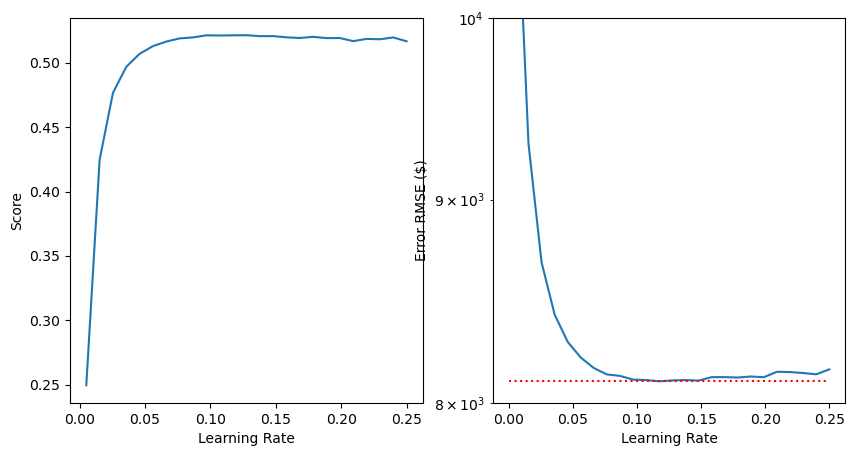

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.linspace(0.005,0.25,25), [r['score'] for r in results])
ax[1].plot(np.linspace(0.005,0.25,25), [r['mean_abs_err'] for r in results])
ax[1].plot([0,0.25],[8100,8100], color='r', ls=":")

ax[0].set_xlabel('Learning Rate')
ax[1].set_xlabel('Learning Rate')

ax[0].set_ylabel('Score')
ax[1].set_ylabel('Error RMSE ($)')

ax[1].set_ylim([8000,10000])

plt.yscale('log')

In [35]:
results = []

for v in np.linspace(10,250,25):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate       = 0.15,
                                     max_bins            = 255,
                                     max_iter            = int(v),
                                     categorical_features= tmp,
                                     random_state        = 0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

10.0
Score                          : 0.43
Average Error                  : $9263
Classification (>$50,000) acc. : 93.01
20.0
Score                          : 0.49
Average Error                  : $8526
Classification (>$50,000) acc. : 93.36
30.0
Score                          : 0.50
Average Error                  : $8306
Classification (>$50,000) acc. : 93.39
40.0
Score                          : 0.51
Average Error                  : $8207
Classification (>$50,000) acc. : 93.43
50.0
Score                          : 0.52
Average Error                  : $8162
Classification (>$50,000) acc. : 93.40
60.0
Score                          : 0.52
Average Error                  : $8139
Classification (>$50,000) acc. : 93.42
70.0
Score                          : 0.52
Average Error                  : $8126
Classification (>$50,000) acc. : 93.37
80.0
Score                          : 0.52
Average Error                  : $8113
Classification (>$50,000) acc. : 93.40
90.0
Score                      

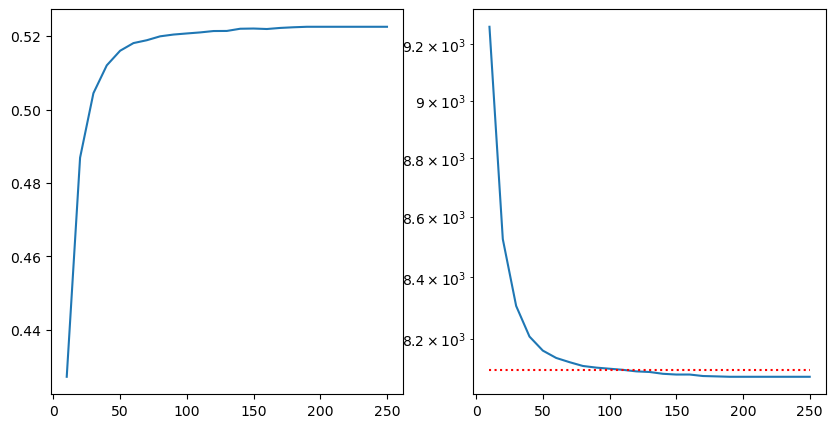

In [36]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.linspace(10,250,25), [r['score'] for r in results])
ax[1].plot(np.linspace(10,250,25), [r['mean_abs_err'] for r in results])
ax[1].plot([10,250],[8100,8100], color='r', ls=":")
plt.yscale('log')

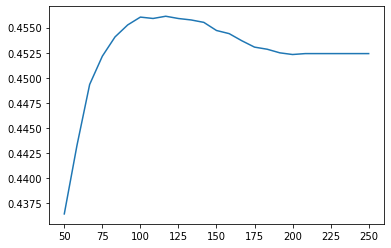

In [37]:
results = []

for v in range(1,10,1):
    print(v)
    model = HistGradientBoostingRegressor( 
                                     learning_rate = 0.15,
                                     max_bins      = 255,
                                     max_depth     = v,
                                     max_iter      = 200,
                                     categorical_features=tmp,
                                     random_state=0).fit(X_train, y_train)
    res = _regression_metrics(model, X_test, y_test)
    
    results += [res]

1
Score                          : 0.45
Average Error                  : $8922
Classification (>$50,000) acc. : 93.16
2
Score                          : 0.49
Average Error                  : $8493
Classification (>$50,000) acc. : 93.38
3
Score                          : 0.51
Average Error                  : $8253
Classification (>$50,000) acc. : 93.45
4
Score                          : 0.52
Average Error                  : $8133
Classification (>$50,000) acc. : 93.52
5
Score                          : 0.52
Average Error                  : $8082
Classification (>$50,000) acc. : 93.46
6
Score                          : 0.52
Average Error                  : $8082
Classification (>$50,000) acc. : 93.50
7
Score                          : 0.52
Average Error                  : $8101
Classification (>$50,000) acc. : 93.45
8
Score                          : 0.52
Average Error                  : $8076
Classification (>$50,000) acc. : 93.40
9
Score                          : 0.52
Average Error   

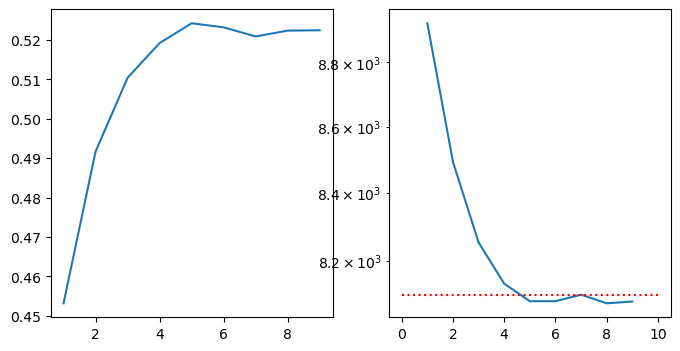

In [38]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(1,10,1), [r['score'] for r in results])
ax[1].plot(range(1,10,1), [r['mean_abs_err'] for r in results])
ax[1].plot([0,10],[8100,8100], color='r', ls=":")
plt.yscale('log')

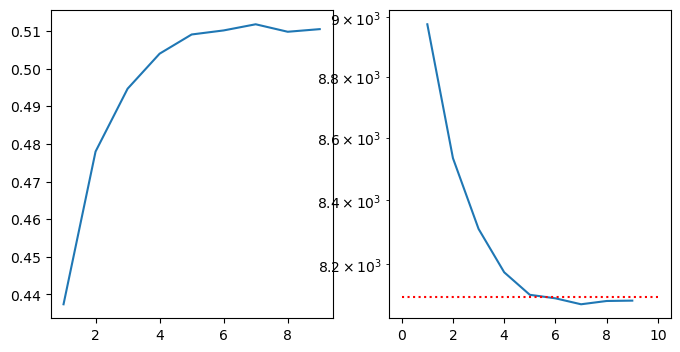

In [41]:
model = HistGradientBoostingRegressor( 
                                 loss         ='absolute_error',
                                 max_bins     = 255,
                                 max_iter     = 200,
                                 learning_rate= 0.15,
                                 max_depth    = 10,
                                 categorical_features=tmp,
                                 random_state = 0).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.50
Average Error                  : $7895
Classification (>$50,000) acc. : 93.60


# Stage 3 :  Model Testing

- We provided some basic metrics, but can we look deeper
- Use our best model and best parameter set (after tuning)

In [42]:
import lime
import lime.lime_tabular

In [43]:
model = HistGradientBoostingRegressor( 
                                     learning_rate = 0.15,
                                     max_bins      = 255,
                                     loss          ='absolute_error',
                                     max_depth     = 20,
                                     max_iter      = 250,
                                     categorical_features=tmp,
                                     random_state  =0).fit(X_train, y_train)
_ = _regression_metrics(model, X_test, y_test)

Score                          : 0.50
Average Error                  : $7883
Classification (>$50,000) acc. : 93.63


In [44]:
feature_names = [x for x in list(df_X.columns) if x!=TARGET]

explainer = lime.lime_tabular.LimeTabularExplainer(
   X_train, 
   feature_names       = feature_names, 
   categorical_features= np.argwhere(tmp).flatten(), 
   verbose             = True, 
   mode                = 'regression')

In [46]:
i = 2

xi,yi = X_test[i], y_test[i]
exp   = explainer.explain_instance(xi, 
                                 model.predict, 
                                 num_features=20)
exp.show_in_notebook(show_table=True)

Intercept 16193.069584841984
Prediction_local [15624.84172645]
Right: 13887.811245978066


## 3.2 Variational Testing

In [47]:
# extract a dictionary input
features = [c for c in df_X.columns if c != TARGET] # [c for c in keep_cols if c != TARGET]
assert len(features) == X_train.shape[1]

xi = {k:i for k,i in zip(features, X_train[3])}

print(y_train[3])
xi_inv = xi.copy()
for k,v in xi.items():
    if k in lecs:
        xi_inv[k] = lecs[k].inverse_transform([int(v)])[0]
xi_inv

32000.0


{'AGE': 57.0,
 'ANCSTRY1': 51.0,
 'CLASS': 'Emp. of a Private for Profit Company or',
 'DISABL1': 2.0,
 'FEB55': 1.0,
 'FERTIL': 0.0,
 'HOUR89': 40.0,
 'HOURS': 40.0,
 'IMMIGR': 0.0,
 'INDUSTRY': 762.0,
 'MARITAL': 'Now Married, Except Separated',
 'MEANS': 'Car, Truck, or Van',
 'MILITARY': 1.0,
 'OCCUP': 999.0,
 'POWPUMA': 200.0,
 'RAGECHLD': 'N/a Male',
 'RELAT1': 0.0,
 'RPOB': 'Northeast',
 'SCHOOL': 1.0,
 'SEPT80': 0.0,
 'SEX': 'Male',
 'TRAVTIME': 10.0,
 'WEEK89': 52.0,
 'WWII': 0.0,
 'YEARSCH': 10.0,
 'YRSSERV': 20.0,
 'OCCUP_SUM': 'SERVICE OCCUPATIONS',
 'POB_USA': 1.0}

In [48]:
def _predict_from_dict(model, xi, encoders: dict, scaler=None):
    
    categorical_vars = list(encoders.keys())
    
    for feature in categorical_vars:
        xi[feature] = encoders[feature].transform(np.array(xi[feature]).reshape(1,))[0]
    
    labels = list(xi.keys())
    
    if scaler:
        xi = scaler.transform(pd.DataFrame(np.array(list(xi.values())).reshape(1,-1), 
                                           columns=xi.keys()))  
    else:
        xi = np.array(list(xi.values())).reshape(1,-1)
    
#     xi = pd.DataFrame(xi, columns=labels)
    
    ri = model.predict(xi)

    return ri

In [49]:
lecs['SEX'].transform(['Female'])

array([0])

In [53]:
all_codes['OCCUP']

{'000': 'N/a Less Than 16 Yrs. Old/unemp. Who Nev'}

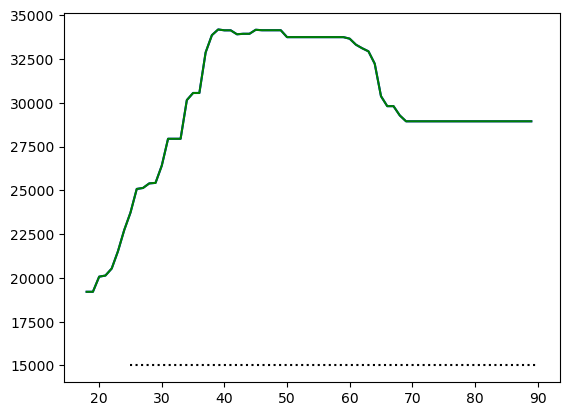

In [56]:
xi = {'AGE': 57.0,
 'ANCSTRY1': 51.0,
 'CLASS': 'Emp. of a Private for Profit Company or',
 'DISABL1': 2.0,
 'FEB55': 1.0,
 'FERTIL': 0.0,
 'HOUR89': 40.0,
 'HOURS': 40.0,
 'IMMIGR': 0.0,
 'INDUSTRY': 762.0,
 'MARITAL': 'Now Married, Except Separated',
 'MEANS': 'Car, Truck, or Van',
 'MILITARY': 1.0,
 'OCCUP': 999.0,
 'POWPUMA': 200.0,
 'RAGECHLD': 'N/a Male',
 'RELAT1': 0.0,
 'RPOB': 'Northeast',
 'SCHOOL': 1.0,
 'SEPT80': 0.0,
 'SEX': 'Male',
 'TRAVTIME': 10.0,
 'WEEK89': 52.0,
 'WWII': 0.0,
 'YEARSCH': 15.0,
 'YRSSERV': 10.0,
 'OCCUP_SUM': 'SERVICE OCCUPATIONS',
 'POB_USA': 1.0}
# _predict_from_dict(model, xi.copy(), lecs)

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 'Female'
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 'Male'
    res += [_predict_from_dict(model, xi.copy(),  lecs)]

plt.plot(range(18,90,1), res, color="g")

plt.plot([25,90], [15000,15000], color="black", ls=":")
# plt.ylim([0.25,0.75])

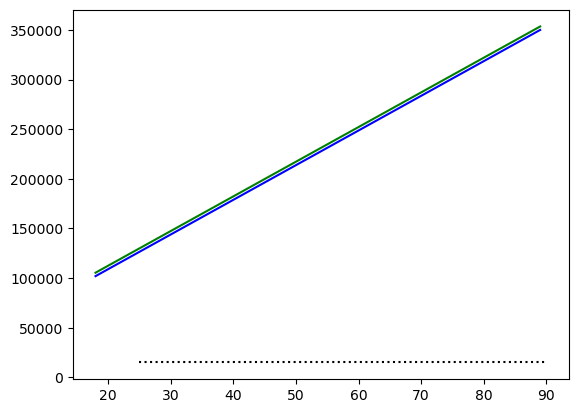

In [104]:
# scale features so we can compare the size of the coefficients
X_train, y_train, X_test, y_test = _split_data(df_X, target=TARGET, scaler=None, shuffle=True)
print(f"Training data : {X_train.shape[0]} \nTest data     : {X_test.shape[0]}")

# extract a dictionary input
features = [c for c in df_X.columns if c != TARGET] # [c for c in keep_cols if c != TARGET]
assert len(features) == X_train.shape[1]

xi = {k:i for k,i in zip(features, X_train[1])}

print(y_train[3])
xi_inv = xi.copy()
for k,v in xi.items():
    if k in lecs:
        xi_inv[k] = lecs[k].inverse_transform([int(v)])[0]
xi_inv

xi = {'AGE': 42.0,
 'ANCSTRY1': 32.0,
 'ANCSTRY2': 999.0,
 'CITIZEN': 1.0,
 'CLASS': 'Self Emp. in Own Incorp.d Business, Prof',
 'DEPART': 0.0,
 'DISABL1': 2.0,
 'ENGLISH': 0.0,
 'FEB55': 0.0,
 'FERTIL': 0.0,
 'HISPANIC': 0.0,
 'HOUR89': 60.0,
 'HOURS': 60.0,
 'IMMIGR': 0.0,
 'INDUSTRY': 892.0,
 'KOREAN': 0.0,
 'LANG1': 2.0,
 'MARITAL': 'Now Married, Except Separated',
 'MAY75880': 0.0,
 'MEANS': 'Worked At Home',
 'MIGPUMA': 0.0,
 'MILITARY': 0.0,
 'MOBILITY': 1.0,
 'MOBILLIM': 2.0,
 'OCCUP': 26.0,
 'OTHRSERV': 0.0,
 'PERSCARE': 2.0,
 'POB': 'Oklahoma',
 'POWPUMA': 200.0,
 'RACE': 'White 800 869, 971',
 'RAGECHLD': 'N/a Male',
 'RELAT1': 0.0,
 'RIDERS': 0.0,
 'RPOB': 'South',
 'RVETSERV': 0.0,
 'SCHOOL': 1.0,
 'SEPT80': 0.0,
 'SEX': 'Male',
 'TRAVTIME': 0.0,
 'VIETNAM': 0.0,
 'WEEK89': 52.0,
 'WORKLWK': 1.0,
 'WWII': 0.0,
 'YEARSCH': 16.0,
 'YRSSERV': 0.0,
 'YEARSCH_CAT': 'Some Coll., But No Degree',
 'OCCUP_SUM': 'MANAGERIAL AND PROFESSIONAL SPECIALTY OCCUPATIONS',
 'OCCUP_MAJ': 'Executive, Administrative, and Managerial Occupations',
 'INDUSTRY_SUM': 'PROFESSIONAL AND RELATED SERVICES',
 'POB_USA': 1.0,
 'POB_CONTINENT': 'NA',
 'POB_COUNTRY': 'US',
 'POB_STATE': 'Oklahoma'}

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 'Female'
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 'Male'
    res += [_predict_from_dict(model, xi.copy(),  lecs)]

plt.plot(range(18,90,1), res, color="g")

plt.plot([25,90], [15000,15000], color="black", ls=":")
# plt.ylim([0.25,0.75])

In [72]:
# xi = {'OCCUP': 17.0,
#      'INDUSTRY': 641.0,
#      'RACE': 'White 800 869, 971',
#      'SEX': 0.0,
#      'HOURS': 99.0,
#      'AGE': 62.0,
#      'FERTIL': 0.0,
#      'WEEK89': 52.0,
#      'MARITAL': 0.0,
#      'ENGLISH': 2.0,
#      'YRSSERV': 0.0,
#      'MEANS': 1.0,
#      'CITIZEN': 1.0,
#      'YEARSCH': 15.0,
#      'CLASS': 6.0,
#      'DEPART': 530.0}

# _predict_from_dict(model, xi.copy(), lecs)

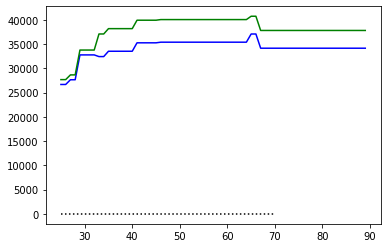

In [378]:
xi = {'OCCUP': 17.0,
     'INDUSTRY': 641.0,
     'RACE' : 'White 800 869, 971',
     'SEX': 0.0,
     'HOURS': 99.0,
     'AGE': 62.0,
     'FERTIL': 0.0,
     'WEEK89': 52.0,
     'MARITAL': 0.0,
     'ENGLISH': 2.0,
     'YRSSERV': 0.0,
     'MEANS': 1.0,
     'CITIZEN': 1.0,
     'YEARSCH': 15.0,
     'CLASS': 6.0,
     'DEPART': 530.0}

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="b")

res = []
for i in range(25,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(25,90,1), res, color="g")

plt.plot([25,70], [0.5,0.5], color="black", ls=":")
# plt.ylim([0.25,0.75])

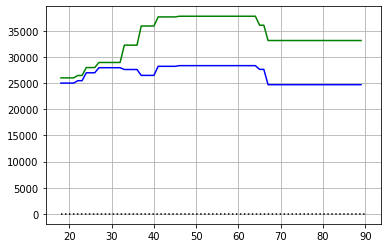

In [390]:
xi = {'OCCUP'  : 8.0,
     'INDUSTRY': 641.0,
     'RACE'    : 'White 800 869, 971',
     'SEX'     : 0.0,
     'HOURS'   : 99.0,
     'AGE'     : 50.0,
     'FERTIL'  : 0.0,
     'WEEK89'  : 52.0,
     'MARITAL' : 0.0,
     'ENGLISH' : 2.0,
     'YRSSERV' : 0.0,
     'MEANS'   : 1.0,
     'CITIZEN' : 1.0,
     'YEARSCH' : 15.0,
     'CLASS'   : 6.0,
     'DEPART'  : 530.0}

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 1 # female
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="b")

res = []
for i in range(18,90,1):
    xi['AGE'] = i
    xi['SEX'] = 0 # male
    res += [_predict_from_dict(model, xi.copy(),  lecs)]
plt.plot(range(18,90,1), res, color="g")

plt.plot([18,90], [0.5,0.5], color="black", ls=":")
plt.grid()
# plt.ylim([0.25,0.75])

# Bonus : Deep Learning

- We started simple according to our own rules; but we can now see if deep learning can do better.

- MLP is the appropriate architecture (it is also the simplest)
- We denseley connect all neurons so complex relationships between any two variables can be built
- The dataset size does not justify large models, and we prefer shallow, wide networks

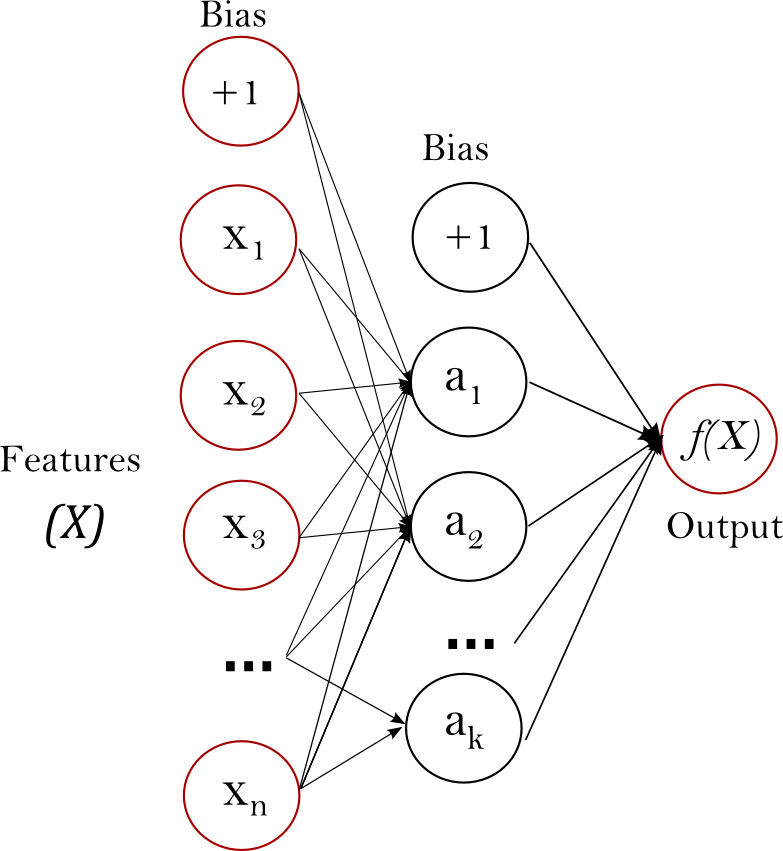

As it turns out, deep learning can achieve good performance but not best without tuning. The expense of the training procedure and the size of the model (and explainability) both count against DL and make something simpler a much better option for this problem.

**Why DL didn't have bets performance**
- Small dataset size
- Mostly linear relationships, don't need DL complexity
- Lack of DL tuning

In [105]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [106]:
keep_cols

['AGE',
 'ANCSTRY1',
 'CLASS',
 'DISABL1',
 'FEB55',
 'FERTIL',
 'HOUR89',
 'HOURS',
 'IMMIGR',
 'INDUSTRY',
 'MARITAL',
 'MEANS',
 'MILITARY',
 'OCCUP',
 'POWPUMA',
 'RAGECHLD',
 'REARNING',
 'RELAT1',
 'RPOB',
 'SCHOOL',
 'SEPT80',
 'SEX',
 'TRAVTIME',
 'WEEK89',
 'WWII',
 'YEARSCH',
 'YRSSERV',
 'OCCUP_SUM',
 'POB_USA']

In [134]:
df_X, _ = _prepare_data(df, 
                        target      = TARGET, 
                        cols        = keep_cols,
                        cat_cols    = [c for c in keep_cols if c not in num_cols],
                        encode_cats = True,
                        verbose     = True)

X_train, y_train, X_test, y_test = _split_data(df_X, 
                                               target=TARGET, 
                                               shuffle=True,
                                               scaler=None)

Cardinalities
ANCSTRY1                  : 255
CLASS                     : 8
DISABL1                   : 2
FEB55                     : 2
IMMIGR                    : 11
INDUSTRY                  : 243
MARITAL                   : 5
MEANS                     : 12
MILITARY                  : 2
OCCUP                     : 504
POWPUMA                   : 108
RAGECHLD                  : 5
RELAT1                    : 13
RPOB                      : 14
SCHOOL                    : 3
SEPT80                    : 2
SEX                       : 2
WWII                      : 2
YEARSCH                   : 17
OCCUP_SUM                 : 7
POB_USA                   : 2


In [108]:
# prove we can overfit to the solution
clf = MLPRegressor(
#     alpha = 0.0001,
    hidden_layer_sizes = (X_train.shape[1]+1,10),
    random_state       = 1, 
    max_iter           = 10,
    learning_rate_init = 0.001,
    verbose            = True).fit(np.concatenate((X_train, y_train.reshape((-1,1))), axis=1), y_train)

Iteration 1, loss = 5762294.43960111
Iteration 2, loss = 0.99771188
Iteration 3, loss = 20.85150323


/Users/tom.jubb/anaconda3/envs/dio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [135]:


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [137]:
clf = MLPRegressor(
                hidden_layer_sizes=(X_train.shape[1],
                                    X_train.shape[1]//2,
                                    X_train.shape[1]//2,
                                   ),
                random_state      = 0, 
                activation = 'relu',
                max_iter          = 300,
                alpha             = 1e-9,
                learning_rate_init= 0.005,
#                 batch_size        = 512,
                verbose           = False)
test_loss = []
for i in range(10):
    clf.partial_fit(X_train[:100000], y_train[:100000])
    loss = np.abs((clf.predict(X_test) - y_test)).mean()
    test_loss += [loss]
    print(f"Epoch {str(i).zfill(3)}/{250} : TRAIN : ${np.sqrt(clf.loss_):.2f} TEST : ${loss:.2f}")

Epoch 000/250 : TRAIN : $15542.35 TEST : $11240.30
Epoch 001/250 : TRAIN : $10809.60 TEST : $10262.20
Epoch 002/250 : TRAIN : $10458.19 TEST : $10063.41
Epoch 003/250 : TRAIN : $10350.46 TEST : $9989.01
Epoch 004/250 : TRAIN : $10294.51 TEST : $9928.67
Epoch 005/250 : TRAIN : $10253.09 TEST : $9876.51
Epoch 006/250 : TRAIN : $10220.27 TEST : $9834.37
Epoch 007/250 : TRAIN : $10194.11 TEST : $9801.95
Epoch 008/250 : TRAIN : $10173.18 TEST : $9777.37
Epoch 009/250 : TRAIN : $10156.30 TEST : $9756.45


TRAIN : $13936.76 TEST : $10523.89
TRAIN : $10938.18 TEST : $9906.33
TRAIN : $10650.12 TEST : $9698.11
TRAIN : $10521.07 TEST : $9612.86
TRAIN : $10453.90 TEST : $9561.24
TRAIN : $10408.75 TEST : $9515.58
TRAIN : $10373.37 TEST : $9478.31
TRAIN : $10344.17 TEST : $9443.02
TRAIN : $10319.28 TEST : $9410.15
TRAIN : $10297.58 TEST : $9381.96
TRAIN : $10277.95 TEST : $9355.70
TRAIN : $10261.02 TEST : $9332.28
TRAIN : $10245.85 TEST : $9309.62
TRAIN : $10232.76 TEST : $9296.72
TRAIN : $10220.84 TEST : $9282.59
TRAIN : $10210.45 TEST : $9269.72
TRAIN : $10200.30 TEST : $9255.17
TRAIN : $10191.55 TEST : $9238.11
TRAIN : $10183.31 TEST : $9226.89
TRAIN : $10175.71 TEST : $9214.66
TRAIN : $10168.96 TEST : $9206.59
TRAIN : $10162.37 TEST : $9193.23
TRAIN : $10156.51 TEST : $9188.36
TRAIN : $10150.43 TEST : $9185.00
TRAIN : $10144.47 TEST : $9173.44
TRAIN : $10139.37 TEST : $9165.71
TRAIN : $10134.26 TEST : $9158.70
TRAIN : $10129.25 TEST : $9152.01
TRAIN : $10124.29 TEST : $9146.13
TRAIN : $1011

TRAIN : $9770.32 TEST : $8732.75
TRAIN : $9769.07 TEST : $8737.15
TRAIN : $9768.47 TEST : $8734.38


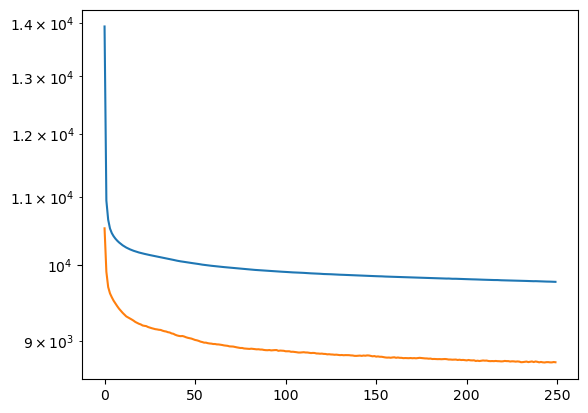

In [254]:
plt.plot(np.sqrt(clf.loss_curve_))
plt.plot(test_loss)
plt.yscale('log')